# Counting Subgraphs with PACT

This notebook is intended as a quick practical introduction for the most basic way to count subgraphs using **PACT (PAttern Counting Toolkit)**.

We will work through a running example in which we want to count the how often all 7 node trees occur as subgraphs in an example host graph. The folder `data/tutorial` should contain files describing all of our pattern graphs (the trees with 7 nodes), the full *spasm base* of our patterns, and a host graph file `schi_pombe.gml`. The pattern and spasm base graphs were created with nauty (their creation process is described in detail at the end of this tutorial).  Our example host graph is the PPI network of *Schizosaccharomyces pombe* (fission yeast), derived from the [BioGRID](https://thebiogrid.org/) dataset.


# Part 1: Pattern Precomputations

Our overall intention is to compute the number of times a pattern $P$ occurrs as a subgraph in hostgraph $H$, in short we write $\#Sub(P \rightarrow H)$ for this number. We will do so using the following identity:

$$\#Sub(P \rightarrow H) = \sum_{F \in Spasm(P)} \mu(F,P) \cdot \#Hom(F \rightarrow H)$$

where
  - $Spasm(P)$ is the set of all homomorphic loop-free images of $P$,
  - $\mu(F,P)$ is a coefficient depending on $P$ and $H$, and
  -  $\#Hom(F \rightarrow H)$ is the number of homomorphisms from $F$ into $H$.
  
We will refer to the set $Spasm(P)$ together with the corresponding coefficients $\mu$ as the *homomorphism base* of $P$. Computing the homomorphism base as well as $\#Hom$ is computationally expensive, but more flexible and cheaper (for larger patterns) than other known methods of obtaining $\#Sub(P \rightarrow H)$. 

Note that the identity is not a heuristic or similar, the resulting count is the **exact** number of non-induced subgraph occurrences of $P$ in $H$.

In [1]:
%load_ext rich
%load_ext autoreload
%autoreload 2
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
plt.rcParams["figure.figsize"] = (2, 2)

## Loading the Patterns

For convenience we use the settings module for a unified interface to input files for different scenarios. Ideally, simply switching the imported settings allows us to seemlessly change the analysed patterns and spasm graphs.

The individual graphs are stored as `GraphWrapper` objects, which wraps networkx graphs with various additional information that will be useful for our subgraph counting process, like a unique `id`. We do nothing else special with the patterns and just store them in a standard python contain (here a dictionary, indexed by the graphs internal id).

In [2]:
import settings.tutorial as settings
from pact.graphwrapper import GraphWrapper

patterns = dict()

with open(settings.raw_pattern_filename(), 'r') as f:
    lines = map(str.rstrip, f.readlines())
    for line in lines:
        G = GraphWrapper.from_g6str(line, **settings.PATTERN_GRAPHWRAPPER_PARAMS)
        patterns[G.id] = G

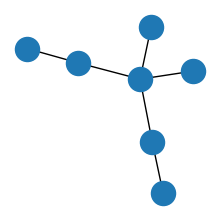

In [3]:
ex_pat = list(patterns.values())[-2]
nx.draw(ex_pat.graph)

## The Spasm Space

In the basic usage of PACT for subgraph counting we also explicitly specify a *spasm space*. Formally this is a set of graphs $S$ such that $Spasm(P) \subseteq S$ for each pattern $P$ that we want to count.

Since our patterns are all the trees with 7 nodes, we know that the spasm space must contain all connected graphs with at most 7 nodes and 6 edges.

The spasm space is stored in a special `SpasmSpace` object, which implements various techniques for optimising later computations.

In [4]:
from pact.spasmspace import SpasmSpace

spasm_space = SpasmSpace()

for sf in settings.raw_spasm_filenames():
    with open(sf) as f:
        lines = list(map(str.rstrip, f.readlines()))
        spasm_space.add_from_g6lines(lines, settings.SPASM_GRAPHWRAPPER_PARAMS)

We'll get an example graph `ex_graph` from the spasm space to illustrate some operations going forward.

To get an interesting graph we can use the `iter_by_ev(x, y)` method which gives us an iterator over all graphs in the spasm space with *x* edgs and *y* vertices. We can then draw the graph using networkx by accessing the graph attribute, which stores the networkx graph inside our wrapped graph.

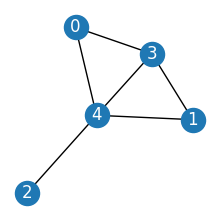

In [5]:
ex_graph = next(spasm_space.iter_by_ev(6,5))
nx.draw(ex_graph.graph, with_labels=True, font_color='w')

## Computing the Homomorphism Base of Patterns

The homomorphism base of a graph $P$ are those graphs in the spasm space for which the coefficient $\mu_F$ in the sum above is not zero. This can be quite costly to compute for larger patterns, but it is independent of the host graph and can therefore be pre-computed once.

The `hombase_coeffs` function is the basic way to compute the homomorphism base. The function takes as a second parameter a spasm space that must contain all possible graphs in the spasm of the pattern $P$. The homomorphism base is returned as a dictionary with elements of the form $id(F): \mu(F,P)$ for each graph $F$ in the spasm of $P$. The id's refer to the id of $F$ in the given spasm space.

Since we will have to deal with very large numbers of homomorphisms, high precision arithmetic is important here. For this we use the [gmpy2](https://gmpy2.readthedocs.io/en/latest/index.html) package which provides python bindings for the [GNU Multiprecission](https://gmplib.org/) library. In particular, we use the `mpq` type for rational numbers as the coefficients are guaranteed to be rational.

In [6]:
from pact.hombase import hombase_coeffs

hombase_coeffs(ex_pat, spasm_space)

{
    165850954815882573261101579101827098358: mpq(-3,1),
    78333310855796287558858939065325830954: mpq(35,2),
    303414898855562656201290561786245995556: mpq(10,1),
    110549758256875373219715569694639490195: mpq(-8,1),
    223136372572965624571741167172143352088: mpq(-3,2),
    47693011321269647785466125402148551179: mpq(-79,4),
    152037926432527496922685215149030498609: mpq(-9,2),
    126566733879806345007262758929160877404: mpq(-27,4),
    187796408876607823777095462536150071883: mpq(3,1),
    307964237826510534580715546567473953988: mpq(3,2),
    104568620648266557291130478952926438888: mpq(9,2),
    130698121361272427350831300242843799656: mpq(5,4),
    168903408828495428992596687292682726914: mpq(2,1),
    223815617000840717351559801460551249083: mpq(1,2),
    293772219755276500713190244351019427011: mpq(9,2),
    225362980691488088278311700040940134807: mpq(7,4),
    219835990489705635338700540817960664575: mpq(1,2),
    263575285651566782557558127486509419551: mpq(-5,4),
    319237159168907457379966915349929167706: mpq(-1,1),
    104910323149882966727021637135447736987: mpq(-1,2),
    319010079056079060980982168407474270157: mpq(-1,4),
    111650816021472813109846799907404607326: mpq(-1,4),
    17347575028682568824563806773706424345: mpq(-1,2),
    338163571304105284126756706272513642721: mpq(1,4)
}

The standard pattern for computing all homomorphism bases of our patterns is the following.

The iteration here is wrapped inside a `rich.Progress` track as computation can take a while for large (or many) patterns and a progress indicator is helpful.

Homomorphism bases are stored in the `hombase` attribute of a `GraphWrapper`.

In [7]:
from pact.ui import default_progressbar

with default_progressbar() as progress:
    track = progress.track(patterns.values(), total=len(patterns))
    for pattern in track:
        pattern.hombase = hombase_coeffs(pattern, spasm_space)


Output()

## Precompute Decompositions for the Spasm Space

As outlines above, we will count the subgraph occurrences of our patterns by counting the number of homomorphisms from graphs in the spasm space. 

To count the homomorphisms effectively we use dynamic programming on tree decompositions. This is again independent of the host graph and can be done in another pre-computation phase (note that there is no dependence on the homomorphism base computation above).

There are some technical details involved in this process that will be documented separately in the future. For now, this standard pattern will suffice to compute decompositions. (The `times` parameter scales the number of attempts to find a good decomposition. Better decompositions will lead to faster homomorphism counting.)

Decompositions are stored in the `td` attribute of a `GraphWrapper`.

In [8]:
from pact.balgowrapper import balgo_multitry_for_cheapest_decomp

with default_progressbar() as progress:
    track = progress.track(spasm_space.graphs_iter(), len(spasm_space))
    for G in track:
        decomp, badness = balgo_multitry_for_cheapest_decomp(G, times=10)
        G.td = decomp
        G.td_badness = badness

Output()

Decompositions support some basic pretty printing for inspection.

In [9]:
ex_graph.td

B: {1, 3, 4}    λ: ['E_5', 'E_3']
  B: {2, 4}     λ: ['E_4']
  B: {0, 3, 4}  λ: ['E_1', 'E_0']
  B: {1, 3}     λ: ['E_2']

## From Decompositions to Homomorphism Counting Plans

In a final preperatory phase we translate decompositions into execution plans. These plans abstractly describe the steps that should be taken to compute homomorphism count. 

Plans are expected to be stored in the `plan` attribute of `GraphWrapper` objects.

In [10]:
from pact.planner import node_to_ops

for G in spasm_space.graphs_iter():
    G.plan = node_to_ops(G.td)

Plans support human readable ouput. Technically, a plan is simply a `deque` of `code.Operation` objects. The plan is to be read in sequence but ultimately it is up to the execution engine how to execute it. A more detailed explanation of the individual operations will follow.

In [11]:
ex_graph.plan

deque([
    ⍴: _edge_base -> E_5(3, 4),
    ⍴: _edge_base -> E_3(1, 4),
    node$0 = E_5 ⨝ E_3 (on {4}),
    node$0 = project node$0 to {1, 3, 4},
    ⍴: _edge_base -> node$1(2, 4),
    ⍴: _edge_base -> E_1(0, 4),
    ⍴: _edge_base -> E_0(0, 3),
    node$2 = E_1 ⨝ E_0 (on {0}),
    node$2 = project node$2 to {0, 3, 4},
    ⍴: _edge_base -> node$3(1, 3),
    node$0 = node$0 ⋉ node$3 (on {1, 3}),
    node$1 = Count extensions of {4} in node$1,
    node$0 = Merge count from node$1({4}) into node$0,
    node$2 = Count extensions of {3, 4} in node$2,
    node$0 = Merge count from node$2({3, 4}) into node$0
])

# Part 2: Execution on Host Graphs

With everything now in place, all that is left is to actually compute the $\#Hom(F \rightarrow H)$ terms of our original formula for $\#Sub(P \rightarrow H)$ for specific host graphs $H$.

## Loading the Host Graph

The required format for the host graph depends on which execution engine is used. In this tutorial we will use the *naive pandas execution engine*, which takes as input a `pandas.DataFrame` that represents the edge relation of our host graph. The dataframe must have attributes `s` and `t`, source and target, respectively. 

Note that an edge $\{a,b\}$ in an undirected graph must have two entries in the relation, one $(a,b)$ and one $(b,a)$. 

In [12]:
import pandas as pd

host_nx = nx.read_gml('data/tutorial/schi_pombe.gml', label=None)

# IMPORTANT: for undirected graphs we need both directions in our edge relation
edges = [{'s': a, 't': b} for a,b in host_nx.edges()] + [{'s': b, 't': a} for a,b in host_nx.edges()]
host_df = pd.DataFrame(edges).drop_duplicates()

## Executing Counting Plans

The plan of a graph G form a list of instructions which can be executed to count the number of homomorphisms from G into the host graph. In particular, for a `GraphWrapper` object with a plan, we can execute the plan on a given host using different execution backends.

At the moment only one such backend exists: the naive pandas backend executes the instructions directly as given using pandas for the heavy lifting. The homomorphism count can be computed via this backend with the `naive_pandas_homcount(G, H)` function, which directly returns $\#Hom(G \rightarrow H)$. Note that as described above $H$ is passed as an edge relation in a `pandas.DataFrame`.

In [13]:
from pact.naive_exec import naive_pandas_homcount

naive_pandas_homcount(ex_graph, host_df)

454750

## Counting a Pattern

We finally arrive at counting the number of times a pattern occurs as a subgraph of the host. Let us recall our original formula for computing the subgraph count.
$$\#Sub(P \rightarrow H) = \sum_{F \in Spasm(P)} \mu(F,P) \cdot \#Hom(F \rightarrow H)$$
In the previous steps we have computed $Spasm(P)$ as well as all $\mu$ coefficiens, as well as tree decomposition based execution plans for counting $\#Hom(F \rightarrow H)$ for all graphs that occur in the spasms of our patterns.

What is left is to apply the plans to compute the values of $\#Hom(F \rightarrow H)$ for concrete host graphs $H$.
The code below demonstrates how to gather the (non-zero) terms of the above sum for a pattern, and consequently compute the full subgraph count, for our example pattern `ex_pat`. 

Note that because our coefficients use the `gmpy2.mpq` type for precision, this produces `mpq` values which are dispayed as (numerator, denominator) pairs.

In [14]:
hombase_pattern_terms = dict()

for spasm_id, coeff in ex_pat.hombase.items():
    spasm_graph = spasm_space[spasm_id]
    spasm_count = naive_pandas_homcount(spasm_graph, host_df)
    hombase_pattern_terms[spasm_id] = coeff * spasm_count

print('#Sub(P -> H):', sum(hombase_pattern_terms.values()))

# we also display the individual terms of the sum for each F in Spasm(P)
hombase_pattern_terms

#Sub(P -> H): 62638680


{
    165850954815882573261101579101827098358: mpq(-9246,1),
    78333310855796287558858939065325830954: mpq(73815,1),
    303414898855562656201290561786245995556: mpq(238400,1),
    110549758256875373219715569694639490195: mpq(-175888,1),
    223136372572965624571741167172143352088: mpq(-109845,1),
    47693011321269647785466125402148551179: mpq(-1094229,1),
    152037926432527496922685215149030498609: mpq(-1738197,1),
    126566733879806345007262758929160877404: mpq(-2348271,2),
    187796408876607823777095462536150071883: mpq(1534746,1),
    307964237826510534580715546567473953988: mpq(2688111,1),
    104568620648266557291130478952926438888: mpq(3754314,1),
    130698121361272427350831300242843799656: mpq(2565735,2),
    168903408828495428992596687292682726914: mpq(909500,1),
    223815617000840717351559801460551249083: mpq(111938,1),
    293772219755276500713190244351019427011: mpq(12445155,1),
    225362980691488088278311700040940134807: mpq(2177574,1),
    219835990489705635338700540817960664575: mpq(4875256,1),
    263575285651566782557558127486509419551: mpq(-60067845,2),
    319237159168907457379966915349929167706: mpq(-10527076,1),
    104910323149882966727021637135447736987: mpq(-10360537,1),
    319010079056079060980982168407474270157: mpq(-12737789,2),
    111650816021472813109846799907404607326: mpq(-22169881,2),
    17347575028682568824563806773706424345: mpq(-35095743,1),
    338163571304105284126756706272513642721: mpq(280639315,2)
}

## Counting all Patterns

When we want to count the subgraph occurrences for a number of different patterns we can be a bit smarter.
In settings such as our example, many graphs occur in the homomorphism base of multiple patterns. 

Rather than counting their homomorphism counts repeatedly for each pattern, we can instead count the homomorphisms once for every graph in the spasm space and compute the patterns counts all at once.


In [15]:
pattern_counts = {pattern_id: 0 for pattern_id in patterns.keys()}

with default_progressbar() as progress:
    track = progress.track(spasm_space.graphs_iter(), total=len(spasm_space))
    for spasm_graph in track:
        hom_count = naive_pandas_homcount(spasm_graph, host_df)

        for pattern in patterns.values():
            if spasm_graph.id in pattern.hombase:
                coeff = pattern.hombase[spasm_graph.id]
                to_add = hom_count * coeff
                pattern_counts[pattern.id] += to_add

pattern_counts

Output()

{
    314474971788157545568400539705102838785: mpq(68828058,1),
    239481607680695132050448186767691313111: mpq(109656596,1),
    21776057547211374316073301368685686225: mpq(30382730,1),
    277045980633195981452261291108298182780: mpq(53045833,1),
    234581386718133443533829931325137670128: mpq(82915983,1),
    277285981857832108724657477637484472473: mpq(56009486,1),
    338129118357455526220086133060798815993: mpq(50062057,1),
    242641828784396904252110635446514250485: mpq(93357910,1),
    215804242219987587017035894427460650961: mpq(14232418,1),
    41450533916025830176929172712621035049: mpq(62638680,1),
    87464711807959837447482655192647233783: mpq(9372935,1)
}

## Plot the Most Common Patterns

From here on you can analyse our results with whichever tools you prefer. Here is an example of plotting the top counts and plotting the top 3 patterns.

In [16]:
result_df = pd.DataFrame({'pattern': pid, '#Sub': int(c)} for pid, c in pattern_counts.items())

# show the top patterns
result_df.sort_values('#Sub', ascending=False).head()

,pattern,#Sub
1,239481607680695132050448186767691313111,109656596
7,242641828784396904252110635446514250485,93357910
4,234581386718133443533829931325137670128,82915983
0,314474971788157545568400539705102838785,68828058
9,41450533916025830176929172712621035049,62638680


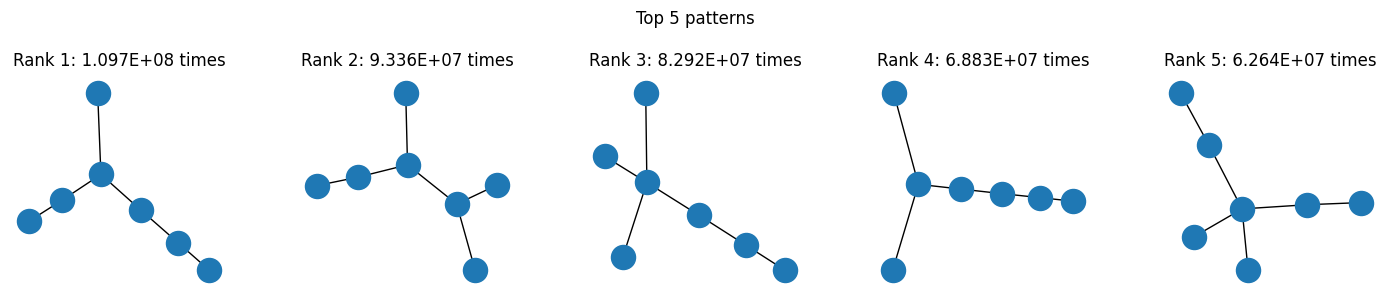

In [17]:
# maybe create a reporting library? or just copy paste for now

def draw_topn_patterns(df, n):
    analysisdf = df

    subcol = [c for c in df.columns if '#Sub' in c][0]
    fig = plt.figure(figsize=(3*n-1,3))
    fig.suptitle(f'Top {n} patterns')
    gs = fig.add_gridspec(nrows=1, ncols=n)

    for i in range(n):
        ax1 = fig.add_subplot(gs[0, i])
        most = analysisdf.sort_values(subcol, ascending=False).iloc[i]
        nx.draw(patterns[most.pattern].graph)
        plt.title(f'Rank {i+1}: {most[subcol]:.3E} times')
    plt.tight_layout(w_pad=5)
    
draw_topn_patterns(result_df, 5)

## Appendix A: Generating the Tutorial Inputs

In [18]:
# TODO